In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.datasets import load_files
from pyvi import ViTokenizer
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit


In [9]:
import pickle 

with open('preprocessing/heart/X.pkl', 'rb') as f:
    X = pickle.load(f)
    X = np.array(X)
with open('preprocessing/heart/y.pkl', 'rb') as f:
    y = pickle.load(f)
    y = np.array(y)

print('So luong du lieu: ', len(X))
print('So luong nhan: ', len(y))

lb = LabelBinarizer()
lb.fit(y)
y = lb.transform(y)
y = y.reshape(1, -1)[0]




So luong du lieu:  1025
So luong nhan:  1025


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=0)

In [11]:
class SVM:
  def __init__(self, kernel='linear', C=10000.0, max_iter=100000, degree=3, gamma=1):
    self.kernel = {'poly'  : lambda x,y: np.dot(x, y.T)**degree,
                   'rbf'   : lambda x,y: np.exp(-gamma*np.sum((y - x[:,np.newaxis])**2, axis=-1)),
                   'linear': lambda x,y: np.dot(x, y.T)}[kernel]
    self.C = C
    self.max_iter = max_iter
  # Giới hạn khoảng alphaj
  def restrict_to_square(self, t, v0, u):
    t = (np.clip(v0 + t*u, 0, self.C) - v0)[1]/u[1]
    return (np.clip(v0 + t*u, 0, self.C) - v0)[0]/u[0]

  def fit(self, X, y):
    self.X = X.copy()
    self.y = y * 2 - 1
    self.lambdas = np.zeros_like(self.y, dtype=float)
    self.K = self.kernel(self.X, self.X) * self.y[:,np.newaxis] * self.y
    
    for _ in range(self.max_iter):
      for idxM in range(len(self.lambdas)):
        idxL = np.random.randint(0, len(self.lambdas))
        Q = self.K[[[idxM, idxM], [idxL, idxL]], [[idxM, idxL], [idxM, idxL]]]
        v0 = self.lambdas[[idxM, idxL]]
        k0 = 1 - np.sum(self.lambdas * self.K[[idxM, idxL]], axis=1)
        u = np.array([-self.y[idxL], self.y[idxM]])
        t_max = np.dot(k0, u) / (np.dot(np.dot(Q, u), u) + 1E-15)
        self.lambdas[[idxM, idxL]] = v0 + u * self.restrict_to_square(t_max, v0, u)
    
    idx, = np.nonzero(self.lambdas > 1E-15)
    self.b = np.mean((1.0 - np.sum(self.K[idx] * self.lambdas, axis=1)) * self.y[idx])
  
  def decision_function(self, X):
    return np.sum(self.kernel(X, self.X) * self.y * self.lambdas, axis=1) + self.b

  def predict(self, X):
    return (np.sign(self.decision_function(X)) + 1) // 2

In [12]:
def cross_validation(estimator):
    _, train_scores, test_scores = learning_curve(estimator, X_, y_, cv=cv, n_jobs=-1, train_sizes=[1.0, ], scoring="accuracy")
    test_scores = test_scores[0]
    mean, std = test_scores.mean(), test_scores.std()
    return mean, std
def plot(title, xlabel, X, Y, error, ylabel = "Accuracy"):
    plt.xlabel(xlabel)
    plt.title(title)
    plt.grid()
    plt.ylabel(ylabel)
    plt.errorbar(X, Y, error, linestyle='None', marker='o')

1.0
5.0
6
10
11
19
20
25
30


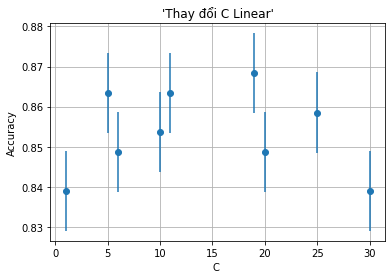

In [13]:
from sklearn.metrics import accuracy_score
title="'Thay đổi C Linear'"
xlabel = "C "
X = []
Y = []
error = []
arr_c=[1.0,5.0,6,10,11,19,20]
for C_test in arr_c:
    print(C_test)
    model=SVM(C=C_test,kernel='linear',max_iter=500)
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    acc=accuracy_score(y_test, y_pred)
  #  print("- Acc = {}".format(acc))
    X.append(C_test)
    Y.append(acc)
    error.append(0.01)
# lưu kết quả ra file ảnh
plot(title, xlabel, X, Y, error)
# plt.savefig('images/KNN_change_K.png', bbox_inches='tight')
plt.show()


1.0
- Acc = 0.6829268292682927
5.0
- Acc = 0.6829268292682927
6
- Acc = 0.6829268292682927
10
- Acc = 0.6829268292682927
11
- Acc = 0.6829268292682927
19
- Acc = 0.6829268292682927
20
- Acc = 0.6829268292682927
25
- Acc = 0.6829268292682927
30
- Acc = 0.6829268292682927


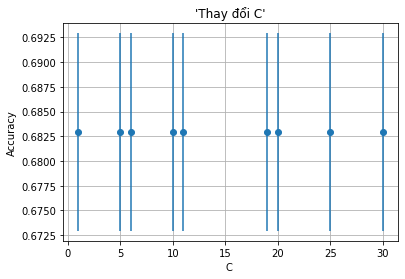

In [ ]:
from sklearn.metrics import accuracy_score
title="'Thay đổi C Poly'"
xlabel = "C "
X = []
Y = []
error = []
arr_c=[1.0,5.0,6,10,11,19,20,25,30]
for C_test in arr_c:
    print(C_test)
    model=SVM(C=C_test,kernel='poly',max_iter=500,gamma=0.001)
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    acc=accuracy_score(y_test, y_pred)
    print("- Acc = {}".format(acc))
    X.append(C_test)
    Y.append(acc)
    error.append(0.01)
# lưu kết quả ra file ảnh
plot(title, xlabel, X, Y, error)
# plt.savefig('images/KNN_change_K.png', bbox_inches='tight')
plt.show()

1.0
- Acc = 0.7560975609756098
5.0
- Acc = 0.8536585365853658
6
- Acc = 0.8780487804878049
10
- Acc = 0.9024390243902439
11
- Acc = 0.9024390243902439
19
- Acc = 0.9024390243902439
20
- Acc = 0.9024390243902439
25
- Acc = 0.9024390243902439
30
- Acc = 0.9024390243902439


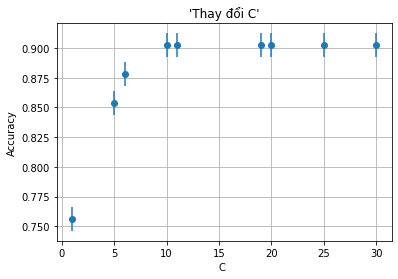

In [ ]:
from sklearn.metrics import accuracy_score
title="'Thay đổi C'"
xlabel = "C "
X = []
Y = []
error = []
arr_c=[1.0,5.0,6,10,11,19,20,25,30]
for C_test in arr_c:
    print(C_test)
    model=SVM(C=C_test,kernel='rbf',max_iter=500,gamma=0.001)
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    acc=accuracy_score(y_test, y_pred)
    print("- Acc = {}".format(acc))
    X.append(C_test)
    Y.append(acc)
    error.append(0.01)
# lưu kết quả ra file ảnh
plot(title, xlabel, X, Y, error)
# plt.savefig('images/KNN_change_K.png', bbox_inches='tight')
plt.show()

- Acc = 0.926829268292683
0.926829268292683
- Acc = 0.9024390243902439
0.9024390243902439
- Acc = 0.9024390243902439
0.9024390243902439
- Acc = 0.8536585365853658
0.8536585365853658
- Acc = 0.8292682926829268
0.8292682926829268
- Acc = 0.8048780487804879
0.8048780487804879
- Acc = 0.8292682926829268
0.8292682926829268
- Acc = 0.8292682926829268
0.8292682926829268


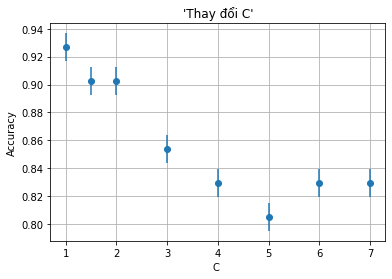

In [54]:
from sklearn.metrics import accuracy_score
title="'Thay đổi C'"
xlabel = "C "
X = []
Y = []
error = []
arr_c=[1.0,1.5,2.0,3.0,4.0,5.0,6.0,7.0]
for C_test in arr_c:
    
    model=svm.SVC(C=C_test,kernel='poly')
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    acc=accuracy_score(y_test, y_pred)
    print("- Acc = {}".format(acc))
    print(acc)
    X.append(C_test)
    Y.append(acc)
    error.append(0.01)
# lưu kết quả ra file ảnh
plot(title, xlabel, X, Y, error)
# plt.savefig('images/KNN_change_K.png', bbox_inches='tight')
plt.show()

In [ ]:
print("- Training ...")


# X_train.shape
print("- Train size = {}".format(X_train.shape))
model=SVM(max_iter=500,kernel='rbf',C=20,gamma=0.001)
print(y_train.dtype)
model.fit(X_train, y_train)
print("- model - train complete")

In [ ]:
from sklearn.metrics import accuracy_score

print("- Testing ...")
y_pred=model.predict(X_test)
print("- Acc = {}".format(accuracy_score(y_test, y_pred)))

In [ ]:
from sklearn.metrics import precision_score, recall_score
recall_s = recall_score(y_test, model.predict(X_test), average=None)
print('Tỉ lệ dự đoán đúng người bị bệnh là ', recall_s[1])
print('Tỉ lệ dự đoán đúng người không bị bệnh là', recall_s[0])

In [ ]:
from sklearn.svm import SVC

title = "thay đổi kernel, C = 1"
xlabel = "kernel"
X = []
Y = []
error = []

for kernel in tqdm(['linear', 'poly', 'rbf', 'sigmoid']):
    # Với mỗi kernel được chọn, 
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = SVC(kernel=kernel, C=1.0)
    mean, std = cross_validation(text_clf)
    X.append(kernel)
    Y.append(mean)
    error.append(std)

# lưu kết quả ra file ảnh 
plot(title, xlabel, X, Y, error)
plt.show()

In [ ]:
title = "thay đổi C, kernel = rbf"
xlabel = "C"
X = []
Y = []
error = []

for C in tqdm([.1, 1.0, 2.0, 5.0, 8.0, 10.0]):
    # Với từng giá trị C nhận được, 
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = SVC(kernel='rbf', C=C)
    mean, std = cross_validation(text_clf)
    X.append(str(C))
    Y.append(mean)
    error.append(std)

# lưu kết quả ra file ảnh
plot(title, xlabel, X, Y, error)
plt.show()

In [ ]:
cv = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state = 0)

train_index, test_index = list(cv.split(X_, y_))[0]
X_train, X_test = X_.iloc[train_index], X_.iloc[test_index]
y_train, y_test = y_.iloc[train_index], y_.iloc[test_index]

# Test với bộ tham số tốt nhất
svm_ = SVC(kernel='rbf', C=2.0)
svm_.fit(X_train, y_train)

print(f'SVM: {accuracy_score(y_test, svm_.predict(X_test))}')